# Load clean data + import

In [55]:
import pandas as pd
books_data_1 = pd.read_csv('clean_data/books_data_clean.csv')
books_ratings_1 = pd.read_csv('clean_data/books_rating_clean.csv')

In [56]:
len(books_data_1)

32932

In [28]:
import numpy as np
import mmh3

# Similar items

## Jaccard Similarity
Function jaccard, that takes two titles and outputs the estimated jaccard similarity.

In [57]:
def jaccard(title1, title2):
    words1 = set(str(title1).lower().split())
    words2 = set(str(title2).lower().split())
    
    # Compute the intersection and union of the sets
    intersection = len(words1.intersection(words2))
    union = len(words1) + len(words2) - intersection
    
    # Calculate the Jaccard similarity
    similarity = intersection / union if union > 0 else 0.0
    
    return similarity

def max_jaccard(title_list):
    max_similarity = 0.0
    idx1 = 0
    idx2 = 0
    for i in range(len(title_list)):
        for j in range(i + 1, len(title_list)):
            similarity = jaccard(title_list[i], title_list[j])
            if similarity > max_similarity:
                idx1 = i
                idx2 = j
                max_similarity = similarity
    return max_similarity,idx1,idx2

# Example usage for comparing two titles
#title1 = books_data_1['title'][0]
#title2 = books_data_1['title'][1]
#print(title1,title2)
#similarity = jaccard(title1, title2)
#print(f"Jaccard Similarity: {similarity}")


# Example usage with a list of titles
n = 100
title_list = books_data_1['title'][0:n]
max_similarity,idx1,idx2 = max_jaccard(title_list)
print(f"Max Jaccard Similarity: {max_similarity}")
print(books_data_1['title'][idx1])
print(books_data_1['title'][idx2])


Max Jaccard Similarity: 0.4
after the fire 
the fire next time


## Similar items using Jaccard similarity

In [58]:
def similar(names, jaccard_threshold=0.6):
    # Create a dictionary to store the similar names
    similar_names = {}
    
    # Loop through each name in the list
    for i in range(len(names)):
        for j in range(i+1, len(names)):
            similarity_score = jaccard(names[i], names[j])
            if similarity_score >= jaccard_threshold:
                similar_names[(names[i], names[j])] = similarity_score
    return similar_names

# Example usage:    
names = books_data_1['title'][0:500]
similar_names = similar(names)
# Print titles in a way that is easier to read

for (desc1, desc2), score in similar_names.items():
    print(f"Similarity Score: {score}")
    print(f"Title 1: {desc1}")
    print(f"Title 2: {desc2}")
    print()


Similarity Score: 0.6
Title 1: the art of the novel
Title 2: the art of loving

Similarity Score: 1.0
Title 1: romola 
Title 2: romola

Similarity Score: 1.0
Title 1: chopin the man and his music
Title 2: chopin  the man and his music

Similarity Score: 0.6
Title 1: the life of david
Title 2: the life of jesus 

Similarity Score: 0.6
Title 1: the holy spirit
Title 2: the baptism with the holy spirit



In [59]:
# Example usage for finding similar descriptions
descritions = books_data_1['description'][0:400]
similar_descriptions = similar(descritions,jaccard_threshold=0.4)

# Print descriptions in a way that is easier to read
for (desc1, desc2), score in similar_descriptions.items():
    print(f"Similarity Score: {score}")
    print(f"Description 1: {desc1}")
    print(f"Description 2: {desc2}")
    print()


Similarity Score: 1.0
Description 1: nan
Description 2: nan



## Locality-Sensitive Hashing

In [60]:
# keep only unique titles in books_data_1
print(len(books_data_1))
books_data_1 = books_data_1.drop_duplicates(subset=['description'], keep='first')
print(len(books_data_1))

32932
25148


In [61]:
len(books_data_1)

25148

In [62]:
names = books_data_1['title'][0:2]
names = names.to_dict()
print(names)

for key, values in names.items():
    print(key)
    print(values)


{0: 'eyewitness travel guide to europe', 1: 'voices from the farm adventures in community living'}
0
eyewitness travel guide to europe
1
voices from the farm adventures in community living


In [63]:
def split_k(word,k):
    if word is np.nan:
        return []
    else:
        n = len(word)
    if k > n:
        return split_k(word,int(k/2))
    else:
        if k == 0:
            return word
        n1 = n//k
        n2 = n1 + n%k
        return [word[i:i+n1] for i in range(0, n, n1)]

In [64]:
# Implement the LSH algorithm
b = 10

def lsh(names, jaccard_threshold,seed):
    lsh_dict = {}
    for key, name in names.to_dict().items():
        blocks = split_k(name,b)
        blocks_hash_values = []
        for aBlock in blocks:
            blocks_hash_values.append(mmh3.hash(aBlock, seed))
        lsh_dict[key] = blocks_hash_values
    list_keys = list(lsh_dict.keys())
    similar_items = {}
    for i in range(len(list_keys)-1):
        if i% 500 == 0:
            print(i)
        for j in range(i+1, len(list_keys)):
            common_values = np.intersect1d(lsh_dict[list_keys[i]], lsh_dict[list_keys[j]])
            if len(common_values) > 0:
                # we found a candidate
                similarity_score = jaccard(names[list_keys[i]], names[list_keys[j]])
                if similarity_score >= jaccard_threshold:
                    similar_items[(list_keys[i], list_keys[j])] = similarity_score
    return similar_items

n = 200

#for (desc1, desc2), score in similar_descriptions.items():
 #   if score == 1:
  #      df = df.drop(desc2)

titles = books_data_1['title'][0:n]
found_similar_items_with_lsh = lsh(titles,jaccard_threshold=0.6,seed=42)
# Print the results
for (title1, title2), score in found_similar_items_with_lsh.items():
    print(f"Similarity Score: {score}")
    print(f"Title 1: {titles[title1]}")
    print(f"Title 2: {titles[title2]}")
    print()
    if score == 1:

        books_data_1 = books_data_1.drop(title2)

0
Similarity Score: 1.0
Title 1: chopin the man and his music
Title 2: chopin  the man and his music



# Results

In [37]:
# Test person seeking for a book
# foundation
# dune
# the picture of dorian gray
# the lion the witch and the wardrobe
# harry potter and the sorcerers stone
# interpreter of maladies

In [65]:
# split a string into k blocks of characters where
def split_k(word,k):
    if word is np.nan:
        return []
    else:
        n = len(word)
    if k > n:
        return split_k(word,int(k/2))
    else:
        if k == 0:
            return word
        n1 = n//k
        n2 = n1 + n%k
        return [word[i:i+n1] for i in range(0, n, n1)]

In [66]:
# Implement the LSH algorithm
b = 10

def lsh(index,names, jaccard_threshold,seed):
    lsh_dict = {}
    for key, name in names.to_dict().items():
        blocks = split_k(name,b)
        blocks_hash_values = []
        for aBlock in blocks:
            blocks_hash_values.append(mmh3.hash(aBlock, seed))
        lsh_dict[key] = blocks_hash_values
    list_keys = list(lsh_dict.keys())
    similar_items = {}
    for i in range(len(list_keys)-1):
       # if i% 1000 == 0:
        #    print(i)
        common_values = np.intersect1d(lsh_dict[list_keys[index]], lsh_dict[list_keys[i]])
        if len(common_values) > 0:
            # we found a candidate
            similarity_score = jaccard(names[index], names[list_keys[i]])
            if similarity_score >= jaccard_threshold:
                similar_items[names[index], list_keys[i]] = similarity_score
    return similar_items



## Foundation
We find the titles in the data set, which have the highest Jaccard similarity with the book "Foundation".

In [67]:
# Which index is book title foundation
title = 'foundation'
index = books_data_1[books_data_1['title'] == title].index[0]
print(index)
print(books_data_1['title'][index])

n = len(books_data_1)
titles = books_data_1['title'][0:n]
found_similar_items_with_lsh = lsh(index,titles,jaccard_threshold=0.2,seed=42)

# Print results
for (title1, index), score in found_similar_items_with_lsh.items():
    print(f"Similarity Score: {score}")
    print(f"Title 1: {title1}")
    print(f"Title 2: {titles[index]}")
    print()

115
foundation
Similarity Score: 0.3333333333333333
Title 1: foundation
Title 2: foundation and earth

Similarity Score: 0.3333333333333333
Title 1: foundation
Title 2: prelude to foundation



## Dune
We find the titles in the data set, which have the highest Jaccard similarity with the book "Dune".

In [68]:
# Which index is book title foundation
title = 'dune'
index = books_data_1[books_data_1['title'] == title].index[0]
print(index)
print(books_data_1['title'][index])

n = len(books_data_1)
titles = books_data_1['title'][0:n]
found_similar_items_with_lsh = lsh(index,titles,jaccard_threshold=0.2,seed=42)

# Print results
for (title1, index), score in found_similar_items_with_lsh.items():
    print(f"Similarity Score: {score}")
    print(f"Title 1: {title1}")
    print(f"Title 2: {titles[index]}")
    print()

847
dune


## The picture of Dorian Gray
We find the titles in the data set, which have the highest Jaccard similarity with the book "The picture of Dorian Gray".

In [69]:
# the picture of dorian gray

# Which index is book title foundation
title = 'the picture of dorian gray'
index = books_data_1[books_data_1['title'] == title].index[0]
print(index)
print(books_data_1['title'][index])

n = len(books_data_1)
titles = books_data_1['title'][0:n]
found_similar_items_with_lsh = lsh(index,titles,jaccard_threshold=0.3,seed=42)

# Print results
for (title1, index), score in found_similar_items_with_lsh.items():
    print(f"Similarity Score: {score}")
    print(f"Title 1: {title1}")
    print(f"Title 2: {titles[index]}")
    print()

3263
the picture of dorian gray
Similarity Score: 0.3333333333333333
Title 1: the picture of dorian gray
Title 2: the big picture

Similarity Score: 0.5555555555555556
Title 1: the picture of dorian gray
Title 2: the picture of dorian gray and other short stories 



## The lion, the witch and the wardrobe
We find the titles in the data set, which have the highest Jaccard similarity with the book "The lion, the witch and the wardrobe".

In [70]:
# the lion the witch and the wardrobe

# Which index is book title foundation
title = 'the lion the witch and the wardrobe'
index = books_data_1[books_data_1['title'] == title].index[0]
print(index)
print(books_data_1['title'][index])

n = len(books_data_1)
titles = books_data_1['title'][0:n]
found_similar_items_with_lsh = lsh(index,titles,jaccard_threshold=0.3,seed=42)

# Print results
for (title1, index), score in found_similar_items_with_lsh.items():
    print(f"Similarity Score: {score}")
    print(f"Title 1: {title1}")
    print(f"Title 2: {titles[index]}")
    print()

4243
the lion the witch and the wardrobe
Similarity Score: 0.3
Title 1: the lion the witch and the wardrobe
Title 2: the girl at the lion dor complete and unabridged



## Harry Potter and the sorceres stone
We find the titles in the data set, which have the highest Jaccard similarity with the book "Harry Potter and the sorceres stone".

In [71]:
# harry potter and the sorcerers stone

# Which index is book title foundation
title = 'harry potter and the sorcerers stone'
index = books_data_1[books_data_1['title'] == title].index[0]
print(index)
print(books_data_1['title'][index])

n = len(books_data_1)
titles = books_data_1['title'][0:n]
found_similar_items_with_lsh = lsh(index,titles,jaccard_threshold=0.4,seed=42)

# Print results
for (title1, index), score in found_similar_items_with_lsh.items():
    print(f"Similarity Score: {score}")
    print(f"Title 1: {title1}")
    print(f"Title 2: {titles[index]}")
    print()

6529
harry potter and the sorcerers stone


## Interpreter of maladies
We find the titles in the data set, which have the highest Jaccard similarity with the book "Interpreter of maladies".

In [72]:
# Which index is book title foundation
if 'interpreter of maladies' in books_data_1['title']:
    title = 'interpreter of maladies'
    index = books_data_1[books_data_1['title'] == title].index[0]
    print(index)
    print(books_data_1['title'][index])

    n = len(books_data_1)
    titles = books_data_1['title'][0:n]
    found_similar_items_with_lsh = lsh(index,titles,jaccard_threshold=0.4,seed=42)

    # Print results
    for (title1, index), score in found_similar_items_with_lsh.items():
        print(f"Similarity Score: {score}")
        print(f"Title 1: {title1}")
        print(f"Title 2: {titles[index]}")
        print()

# Heatmap based on titles
To illustrate which titles that have the highest Jaccard similarity, we have plotted a heatmap.

In [46]:
# Implement the LSH algorithm
b = 10

def lsh(names, jaccard_threshold,seed):
    lsh_dict = {}
    for key, name in names.to_dict().items():
        blocks = split_k(name,b)
        blocks_hash_values = []
        for aBlock in blocks:
            blocks_hash_values.append(mmh3.hash(aBlock, seed))
        lsh_dict[key] = blocks_hash_values
    list_keys = list(lsh_dict.keys())
    similar_items = {}
    for i in range(len(list_keys)-1):
        if i% 500 == 0:
            print(i)
        for j in range(i+1, len(list_keys)):
            common_values = np.intersect1d(lsh_dict[list_keys[i]], lsh_dict[list_keys[j]])
            if len(common_values) > 0:
                # we found a candidate
                similarity_score = jaccard(names[list_keys[i]], names[list_keys[j]])
                if similarity_score >= jaccard_threshold:
                    similar_items[(list_keys[i], list_keys[j])] = similarity_score
    return similar_items

n = 100

titles = books_data_1['title'][0:n]
found_similar_items_with_lsh = lsh(titles,jaccard_threshold=0.6,seed=42)
# Print the results
for (title1, title2), score in found_similar_items_with_lsh.items():
    print(f"Similarity Score: {score}")
    print(f"Title 1: {titles[title1]}")
    print(f"Title 2: {titles[title2]}")
    print()

0


In [47]:
found_similar_items_with_lsh_new = {}
# Remove all with jaccard with score 1 from the dictionary found_similar_items_with_lsh

for (idx1, idx2), score in found_similar_items_with_lsh.items():
    if score < 1.0:
        found_similar_items_with_lsh_new[idx1,idx2] = score

found_similar_items_with_lsh_new

{}

In [48]:
# Plot a heatmap with the found_similar_items_lhs dictionary
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap
def plot_heatmap(found_similar_items_lhs_new):
    # Create a list of keys
    keys = list(found_similar_items_lhs_new.keys())
    
    # Create a list of values
    values = list(found_similar_items_lhs_new.values())
    
    # Create a list of the first items in each key
    key1 = [key[0] for key in keys]
    
    # Create a list of the second items in each key
    key2 = [key[1] for key in keys]
    
    # Create a dataframe with the keys and values
    df = pd.DataFrame({'key1': key1, 'key2': key2, 'values': values})
    
    # Create a pivot table from the dataframe
    df_pivot = df.pivot(index='key1', columns='key2', values='values')
    
    # Create a heatmap from the pivot table
    sns.heatmap(df_pivot, cmap='crest')

    # Add gridlines to the heatmap
    plt.grid()
    
    plt.title('Heatmap of similar book titles')

    # Show the plot
    plt.show()


In [49]:
found_similar_items_with_lsh_new
# Take the 10 pairs with highest similarity score
found_similar_items_with_lsh_new_2 = dict(sorted(found_similar_items_with_lsh_new.items(), key=lambda item: item[1], reverse=True)[20:45])
found_similar_items_with_lsh_new_2

{}

In [51]:
#del found_similar_items_with_lsh_new_2[(26,737)]
#del found_similar_items_with_lsh_new_2[(26,3486)]


In [52]:
found_similar_items_with_lsh_new_2

{}

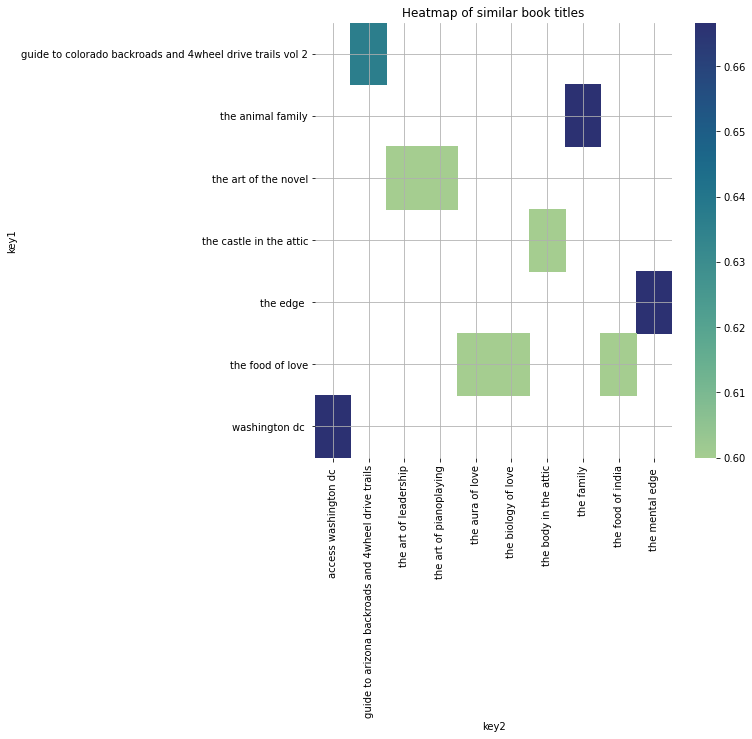

In [ ]:
# plot book titles in stead of keys
plt.figure(figsize=(8,8))
found_similar_items_with_lsh_new_2 = {(titles[key1], titles[key2]): value for (key1, key2), value in found_similar_items_with_lsh_new_2.items()}
plot_heatmap(found_similar_items_with_lsh_new_2)

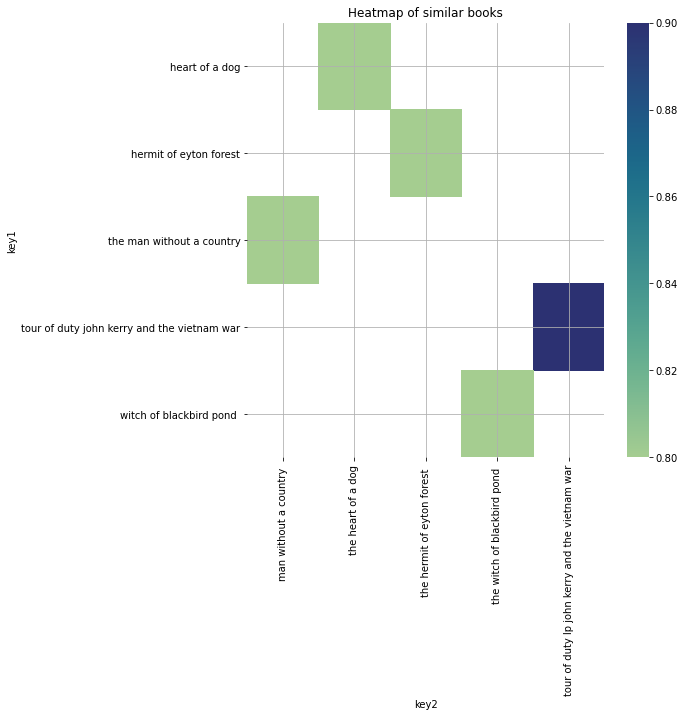

In [ ]:
# plot book titles in stead of keys
plt.figure(figsize=(8,8))
found_similar_items_with_lsh_new = {(titles[key1], titles[key2]): value for (key1, key2), value in found_similar_items_with_lsh_new.items()}
plot_heatmap(found_similar_items_with_lsh_new)

# Heatmap based on descriptions

In [ ]:
# Install the package nltk
# !pip install nltk

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Melissa Ulsøe
[nltk_data]     Jessen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Melissa Ulsøe
[nltk_data]     Jessen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

In [ ]:
def clean_text(text):
    tokens = word_tokenize(text)
    clean_tokens = []
    
    for token in tokens:
        # Convert to lowercase
        token = token.lower()
        
        # Remove punctuation
        if token not in string.punctuation:
            # Remove stopwords
            if token not in stopwords.words('english'):
                clean_tokens.append(token)
    
    return clean_tokens

# Transform output into a single string
def clean_text_string(text):
    tokens = word_tokenize(text)
    clean_tokens = []
    
    for token in tokens:
        # Convert to lowercase
        token = token.lower()
        
        # Remove punctuation
        if token not in string.punctuation:
            # Remove stopwords
            if token not in stopwords.words('english'):
                clean_tokens.append(token)

    return ' '.join(clean_tokens)

# Example usage
test = 'This is a test sentence. It contains punctuation!'
print(clean_text_string(test))


test sentence contains punctuation


In [ ]:
# Remove where descriptions are nan
books_data_1 = books_data_1.dropna(subset=['description'])
len(books_data_1)

26072

In [ ]:
# Take the 200 books with highest n_ratings in a new dataframe
books_data_1 = books_data_1.sort_values('n_ratings', ascending=False)
# Reset index
books_data_2 = books_data_1[0:500].reset_index(drop=True)
len(books_data_2)

500

In [ ]:
test = books_data_2['description'][0]
clean_text_string(test)

'early nineteenth-century england spirited young woman copes suit snobbish gentleman well romantic entanglements four sisters'

In [ ]:
books_data_2.head()

,Unnamed: 0,title,description,authors,published_date,categories,avg_rating,n_ratings
0,5096,pride and prejudice,"In early nineteenth-century England, a spirite...",['Jane Austen'],1995-01-01,['Fiction'],4.582940,5510
1,10289,wuthering heights,Wuthering Heights is the name of Mr. Heathclif...,['Emily Bronte'],NaN,NaN,4.097928,4922
2,3263,the picture of dorian gray,The Picture of Dorian Gray by Oscar Wilde,['Óscar Wilde'],2016-01-24,NaN,4.315643,3241
3,2429,little women or meg jo beth and amy,2018 marks the 150th anniversary of the classi...,['Rey Terciero'],2019-02-05,['Juvenile Fiction'],4.459098,2995
4,5202,the hobbit,Celebrating 75 years of one of the world's mos...,['J. R. R. Tolkien'],2012,['Juvenile Fiction'],4.646341,2542


In [ ]:
books_data_2['description']

0      In early nineteenth-century England, a spirite...
1      Wuthering Heights is the name of Mr. Heathclif...
2              The Picture of Dorian Gray by Oscar Wilde
3      2018 marks the 150th anniversary of the classi...
4      Celebrating 75 years of one of the world's mos...
                             ...                        
495    In this heart-pounding but touchingly romantic...
496    A New England farmer eking out a hardscrabble ...
497    D.C. Detective Alex Cross has seen a lot of cr...
498    Earth is long since dead. On a colony planet, ...
499    "Here was once a velveteen rabbit, and in the ...
Name: description, Length: 500, dtype: object

In [ ]:
# Apply the clean_text_string function to the description column
books_data_2['description_clean'] = books_data_2['description'].apply(clean_text_string)


In [ ]:
# Implement the LSH algorithm
b = 10

def lsh(names, jaccard_threshold,seed):
    lsh_dict = {}
    for key, name in names.to_dict().items():
        blocks = split_k(name,b)
        blocks_hash_values = []
        for aBlock in blocks:
            blocks_hash_values.append(mmh3.hash(aBlock, seed))
        lsh_dict[key] = blocks_hash_values
    list_keys = list(lsh_dict.keys())
    similar_items = {}
    for i in range(len(list_keys)-1):
        if i% 500 == 0:
            print(i)
        for j in range(i+1, len(list_keys)):
            common_values = np.intersect1d(lsh_dict[list_keys[i]], lsh_dict[list_keys[j]])
            if len(common_values) > 0:
                # we found a candidate
                similarity_score = jaccard(names[list_keys[i]], names[list_keys[j]])
                if similarity_score >= jaccard_threshold:
                    similar_items[(list_keys[i], list_keys[j])] = similarity_score
    return similar_items

n = len(books_data_2)

descriptions = books_data_2['description_clean'][0:n]
similar_descriptions = lsh(descriptions,jaccard_threshold=0.1,seed=42)
# Print the results
for (desc1, desc2), score in similar_descriptions.items():
    if score < 1:
        print(f"Similarity Score: {score}")
        print(f"Description 1: {descriptions[desc1]}")
        print(f"Description 2: {descriptions[desc2]}")
        print()

0
Similarity Score: 0.24858757062146894
Description 1: controversial tale friendship tragedy great depression penguin classic seventy-five years since first publication steinbeck ’ tale commitment loneliness hope loss remains one america ’ widely read taught novels unlikely pair george lennie two migrant workers california great depression grasp american dream hustle work living hand-to-mouth existence george lennie plan acre land shack call land jobs ranch salinas valley fulfillment dream seems within grasp even george guard lennie provocations predict consequences lennie 's unswerving obedience things george taught mice men represents experiment form steinbeck described “ kind playable novel written novel form scened set played stands. ” rarity american letters achieved remarkable success novel broadway play three acclaimed films edition features introduction susan shillinglaw one today ’ leading steinbeck scholars seventy years penguin leading publisher classic literature english-sp

In [ ]:
similar_descriptions_new = {}
# Remove all with jaccard with score 1 from the dictionary similar_descriptions

for (idx1, idx2), score in similar_descriptions.items():
    if score < 1.0:
        similar_descriptions_new[idx1,idx2] = score

similar_descriptions_new

{(6, 431): 0.24858757062146894,
 (17, 22): 0.20093457943925233,
 (17, 290): 0.24022346368715083,
 (20, 64): 0.2897727272727273,
 (20, 253): 0.24855491329479767,
 (20, 451): 0.2875,
 (22, 290): 0.23369565217391305,
 (64, 253): 0.24043715846994534,
 (64, 451): 0.2543352601156069,
 (253, 451): 0.24096385542168675}

In [ ]:
similar_descriptions_new

{(6, 431): 0.24858757062146894,
 (17, 22): 0.20093457943925233,
 (17, 290): 0.24022346368715083,
 (20, 64): 0.2897727272727273,
 (20, 253): 0.24855491329479767,
 (20, 451): 0.2875,
 (22, 290): 0.23369565217391305,
 (64, 253): 0.24043715846994534,
 (64, 451): 0.2543352601156069,
 (253, 451): 0.24096385542168675}

In [ ]:
print(books_data_2['title'][17])
print(books_data_2['title'][22])

lord of the flies
emma


In [ ]:
similar_descriptions_titles = {(books_data_2['title'][key1], books_data_2['title'][key2]): value for (key1, key2), value in similar_descriptions_new.items()}
similar_descriptions_titles

{('of mice and men', 'mansfield park'): 0.24858757062146894,
 ('lord of the flies', 'emma'): 0.20093457943925233,
 ('lord of the flies', 'house of mirth'): 0.24022346368715083,
 ('sense and sensibility', 'tess of the durbervilles'): 0.2897727272727273,
 ('sense and sensibility', 'the pearl'): 0.24855491329479767,
 ('sense and sensibility', 'northanger abbey a novel'): 0.2875,
 ('emma', 'house of mirth'): 0.23369565217391305,
 ('tess of the durbervilles', 'the pearl'): 0.24043715846994534,
 ('tess of the durbervilles', 'northanger abbey a novel'): 0.2543352601156069,
 ('the pearl', 'northanger abbey a novel'): 0.24096385542168675}

In [ ]:
# Plot a heatmap with the found_similar_items_lhs dictionary
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap
def plot_heatmap(found_similar_items_lhs_new):
    # Create a list of keys
    keys = list(found_similar_items_lhs_new.keys())
    
    # Create a list of values
    values = list(found_similar_items_lhs_new.values())
    
    # Create a list of the first items in each key
    key1 = [key[0] for key in keys]
    
    # Create a list of the second items in each key
    key2 = [key[1] for key in keys]
    
    # Create a dataframe with the keys and values
    df = pd.DataFrame({'key1': key1, 'key2': key2, 'values': values})
    
    # Create a pivot table from the dataframe
    df_pivot = df.pivot(index='key1', columns='key2', values='values')
    
    # Create a heatmap from the pivot table
    sns.heatmap(df_pivot, cmap='crest')

    # Add gridlines to the heatmap
    plt.grid()
    
    plt.title('Heatmap of similar book descriptions')

    # Show the plot
    plt.show()


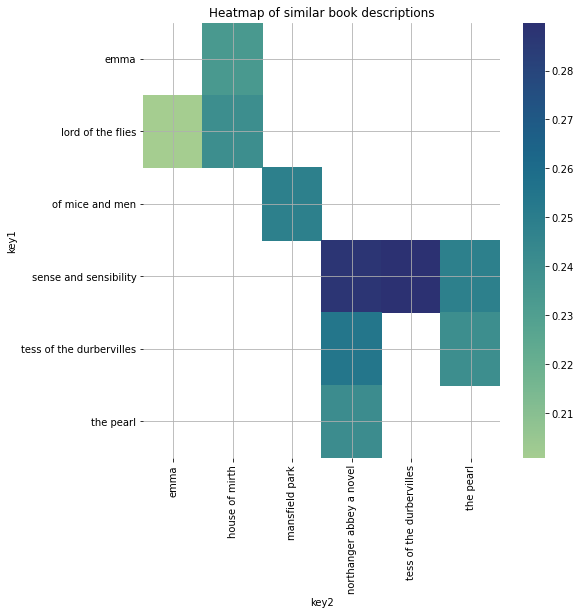

In [ ]:
plt.figure(figsize=(8,8))
plot_heatmap(similar_descriptions_titles)

# Histogram of categories

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
books_data_1['categories']

5096              ['Fiction']
10289                     NaN
3263                      NaN
2429     ['Juvenile Fiction']
5202     ['Juvenile Fiction']
                 ...         
9874            ['Computers']
24705    ['Edible mushrooms']
9875              ['Fiction']
24703             ['Fiction']
32931    ['Juvenile Fiction']
Name: categories, Length: 26072, dtype: object

In [ ]:

# Change dtype of categories to string
# Remove nan from categories
categories = books_data_1['categories'].fillna('').astype(str)
categories = categories.unique()
print(len(categories))
print(categories)
# Find the 10 most frequent categories
# # Crprint(len(categories))


1125
["['Fiction']" '' "['Juvenile Fiction']" ... "['Ghosts']"
 "['Catholic preaching']" "['Edible mushrooms']"]


In [ ]:
# Find the 10 most frequent categories
from collections import Counter
category_counts = Counter(categories)
#print(category_counts.most_common(10))

# Create a list of the most frequent categories
top_categories = [category for category, count in category_counts.most_common(20)]
print(top_categories)

# Remove nan from top_categories
top_categories = [category for category in top_categories if category != 'nan']
# Remove Fiction from top_categories
top_categories = [category for category in top_categories if category != "['Fiction']"]
top_categories = [category for category in top_categories if category != ""]
print(top_categories)
print(len(top_categories))


["['Fiction']", '', "['Juvenile Fiction']", "['Bildungsromans']", "['Young Adult Fiction']", "['Religion']", "['Brothers']", "['Capitalism']", "['FICTION']", "['Science']", "['Education']", "['Foreign Language Study']", "['Ahab, Captain (Fictitious character)']", "['England']", "['Travel']", "['Fantasy']", "['Adventure stories']", "['Business & Economics']", "['Architects']", "['Drama']"]
["['Juvenile Fiction']", "['Bildungsromans']", "['Young Adult Fiction']", "['Religion']", "['Brothers']", "['Capitalism']", "['FICTION']", "['Science']", "['Education']", "['Foreign Language Study']", "['Ahab, Captain (Fictitious character)']", "['England']", "['Travel']", "['Fantasy']", "['Adventure stories']", "['Business & Economics']", "['Architects']", "['Drama']"]
18


In [ ]:
books_data_1['top_category'] = books_data_1['categories'] 

In [ ]:
books_data_1.head()

,Unnamed: 0,title,description,authors,published_date,categories,avg_rating,n_ratings,year,top_category
5096,5096,pride and prejudice,"In early nineteenth-century England, a spirite...",['Jane Austen'],1995-01-01 00:00:00+00:00,['Fiction'],4.582940,5510,1995.0,['Fiction']
10289,10289,wuthering heights,Wuthering Heights is the name of Mr. Heathclif...,['Emily Bronte'],NaT,NaN,4.097928,4922,NaN,NaN
3263,3263,the picture of dorian gray,The Picture of Dorian Gray by Oscar Wilde,['Óscar Wilde'],2016-01-24 00:00:00+00:00,NaN,4.315643,3241,2016.0,NaN
2429,2429,little women or meg jo beth and amy,2018 marks the 150th anniversary of the classi...,['Rey Terciero'],2019-02-05 00:00:00+00:00,['Juvenile Fiction'],4.459098,2995,2019.0,['Juvenile Fiction']
5202,5202,the hobbit,Celebrating 75 years of one of the world's mos...,['J. R. R. Tolkien'],2012-01-01 00:00:00+00:00,['Juvenile Fiction'],4.646341,2542,2012.0,['Juvenile Fiction']


In [ ]:
top_categories

["['Juvenile Fiction']",
 "['Bildungsromans']",
 "['Young Adult Fiction']",
 "['Religion']",
 "['Brothers']",
 "['Capitalism']",
 "['FICTION']",
 "['Science']",
 "['Education']",
 "['Foreign Language Study']",
 "['Ahab, Captain (Fictitious character)']",
 "['England']",
 "['Travel']",
 "['Fantasy']",
 "['Adventure stories']",
 "['Business & Economics']",
 "['Architects']",
 "['Drama']"]

In [ ]:
books_data_2 = books_data_1.dropna(subset=['categories'])

In [ ]:
cats = books_data_2['categories']
# Remove nan from cats
cats.value_counts()

['Fiction']                                         7667
['Juvenile Fiction']                                1692
['Biography & Autobiography']                       1482
['History']                                         1410
['Religion']                                        1305
                                                    ... 
['Beast of the Apocalypse']                            1
['Architecture, Domestic']                             1
['DiGriz, James Bolivar (Fictitious character)']       1
['Hollywood (Los Angeles, Calif.)']                    1
['Computer animation']                                 1
Name: categories, Length: 1124, dtype: int64

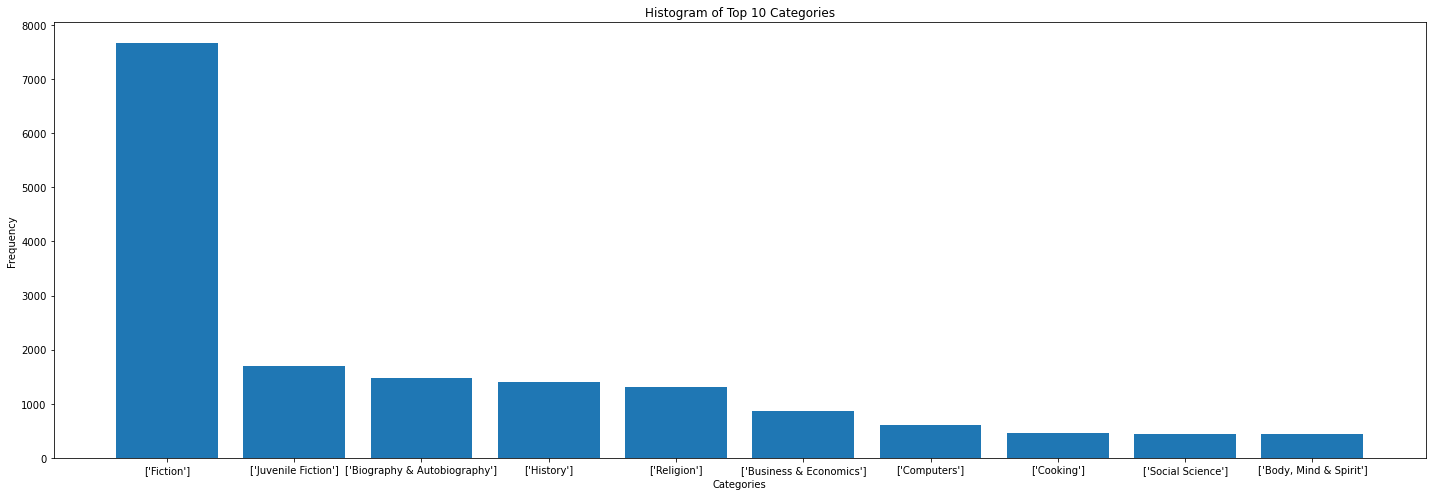

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Make a histogram of the categories

categories_counts = books_data_2['categories'].explode().value_counts()

# Select the top 10 categories
top_categories = categories_counts.head(10)

# Plotting the histogram for the top 10 categories
plt.figure(figsize=(20,7))
plt.bar(top_categories.index, top_categories)
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Histogram of Top 10 Categories')
plt.tight_layout()
plt.show()

# Clustering

In [ ]:
# Find dtypes of books_data_1
books_data_1.head()

,Unnamed: 0,title,description,authors,published_date,categories,avg_rating,n_ratings
5096,5096,pride and prejudice,"In early nineteenth-century England, a spirite...",['Jane Austen'],1995-01-01,['Fiction'],4.582940,5510
10289,10289,wuthering heights,Wuthering Heights is the name of Mr. Heathclif...,['Emily Bronte'],NaN,NaN,4.097928,4922
3263,3263,the picture of dorian gray,The Picture of Dorian Gray by Oscar Wilde,['Óscar Wilde'],2016-01-24,NaN,4.315643,3241
2429,2429,little women or meg jo beth and amy,2018 marks the 150th anniversary of the classi...,['Rey Terciero'],2019-02-05,['Juvenile Fiction'],4.459098,2995
5202,5202,the hobbit,Celebrating 75 years of one of the world's mos...,['J. R. R. Tolkien'],2012,['Juvenile Fiction'],4.646341,2542


In [ ]:
books_data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26072 entries, 5096 to 32931
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      26072 non-null  int64  
 1   title           26071 non-null  object 
 2   description     26072 non-null  object 
 3   authors         25836 non-null  object 
 4   published_date  26030 non-null  object 
 5   categories      25304 non-null  object 
 6   avg_rating      26072 non-null  float64
 7   n_ratings       26072 non-null  int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 1.8+ MB


In [ ]:
books_data_1['published_date']


5096     1995-01-01
10289           NaN
3263     2016-01-24
2429     2019-02-05
5202           2012
            ...    
9874     2001-12-20
24705    2002-02-01
9875     2002-02-26
24703    2011-07-15
32931    2000-06-01
Name: published_date, Length: 26072, dtype: object

In [ ]:
# Convert dtype of published_date to datetime from object
books_data_1['published_date'] = pd.to_datetime(books_data_1['published_date'], format='%Y-%m-%d', errors='coerce', utc=True)

In [ ]:
books_data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26072 entries, 5096 to 32931
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Unnamed: 0      26072 non-null  int64              
 1   title           26071 non-null  object             
 2   description     26072 non-null  object             
 3   authors         25836 non-null  object             
 4   published_date  26026 non-null  datetime64[ns, UTC]
 5   categories      25304 non-null  object             
 6   avg_rating      26072 non-null  float64            
 7   n_ratings       26072 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(2), object(4)
memory usage: 1.8+ MB


In [ ]:
# Make a new column that only contains the year
books_data_1['year'] = books_data_1['published_date'].dt.year

In [ ]:
# Delete rows where year is NaT or inf
books_data_2 = books_data_1[books_data_1['year'].notna()]

In [ ]:
books_data_2['year'] = books_data_2['year'].astype(int)
books_data_2.head()

<ipython-input-317-e19badb3a1f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_data_2['year'] = books_data_2['year'].astype(int)


,Unnamed: 0,title,description,authors,published_date,categories,avg_rating,n_ratings,year
5096,5096,pride and prejudice,"In early nineteenth-century England, a spirite...",['Jane Austen'],1995-01-01 00:00:00+00:00,['Fiction'],4.582940,5510,1995
3263,3263,the picture of dorian gray,The Picture of Dorian Gray by Oscar Wilde,['Óscar Wilde'],2016-01-24 00:00:00+00:00,NaN,4.315643,3241,2016
2429,2429,little women or meg jo beth and amy,2018 marks the 150th anniversary of the classi...,['Rey Terciero'],2019-02-05 00:00:00+00:00,['Juvenile Fiction'],4.459098,2995,2019
5202,5202,the hobbit,Celebrating 75 years of one of the world's mos...,['J. R. R. Tolkien'],2012-01-01 00:00:00+00:00,['Juvenile Fiction'],4.646341,2542,2012
1147,1147,great expectations,Penguin Classics e-books give you the best pos...,['Charles Dickens'],2003-01-30 00:00:00+00:00,['Fiction'],4.365377,2455,2003


In [ ]:
books_data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26026 entries, 5096 to 32931
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Unnamed: 0      26026 non-null  int64              
 1   title           26025 non-null  object             
 2   description     26026 non-null  object             
 3   authors         25790 non-null  object             
 4   published_date  26026 non-null  datetime64[ns, UTC]
 5   categories      25268 non-null  object             
 6   avg_rating      26026 non-null  float64            
 7   n_ratings       26026 non-null  int64              
 8   year            26026 non-null  int32              
dtypes: datetime64[ns, UTC](1), float64(1), int32(1), int64(2), object(4)
memory usage: 1.9+ MB


<ipython-input-323-fdd28ee5e388>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_data_2['cluster'] = kmeans.labels_


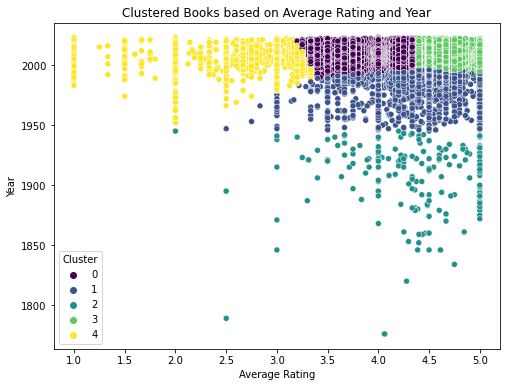

In [ ]:
# Cluster books based on avg_rating and year
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit and transform the data with the scaler
scaled_features = scaler.fit_transform(books_data_2[['avg_rating', 'year']])

# Perform K-Means clustering on the standardized data
kmeans = KMeans(n_clusters=5, random_state=0).fit(scaled_features)

# Add the cluster labels to your DataFrame
books_data_2['cluster'] = kmeans.labels_

# Create a scatter plot of the clusters
plt.figure(figsize=(8, 6))

# Use seaborn to create the scatter plot with different colors for each cluster
sns.scatterplot(x='avg_rating', y='year', data=books_data_2, hue='cluster', palette='viridis')

# Add labels and a legend
plt.xlabel('Average Rating')
plt.ylabel('Year')
plt.title('Clustered Books based on Average Rating and Year')
plt.legend(title='Cluster')

# Show the plot
plt.show()